In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.handlers import mask
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def generate_synthetic_data(
    rng_key: ArrayImpl, n: int, scale: float
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl]:
    x = jnp.linspace(start=0, stop=1, num=n)
    y = jnp.sin(4 * jnp.pi * x) + jnp.sin(7 * jnp.pi * x)
    y_obs = y + scale * random.normal(rng_key, shape=(n,))
    return x, y, y_obs


rng_key, rng_subkey = random.split(rng_key)
x, y, y_obs = generate_synthetic_data(rng_subkey, n=100, scale=0.3)

Text(0.5, 1.0, 'Synthetic Data')

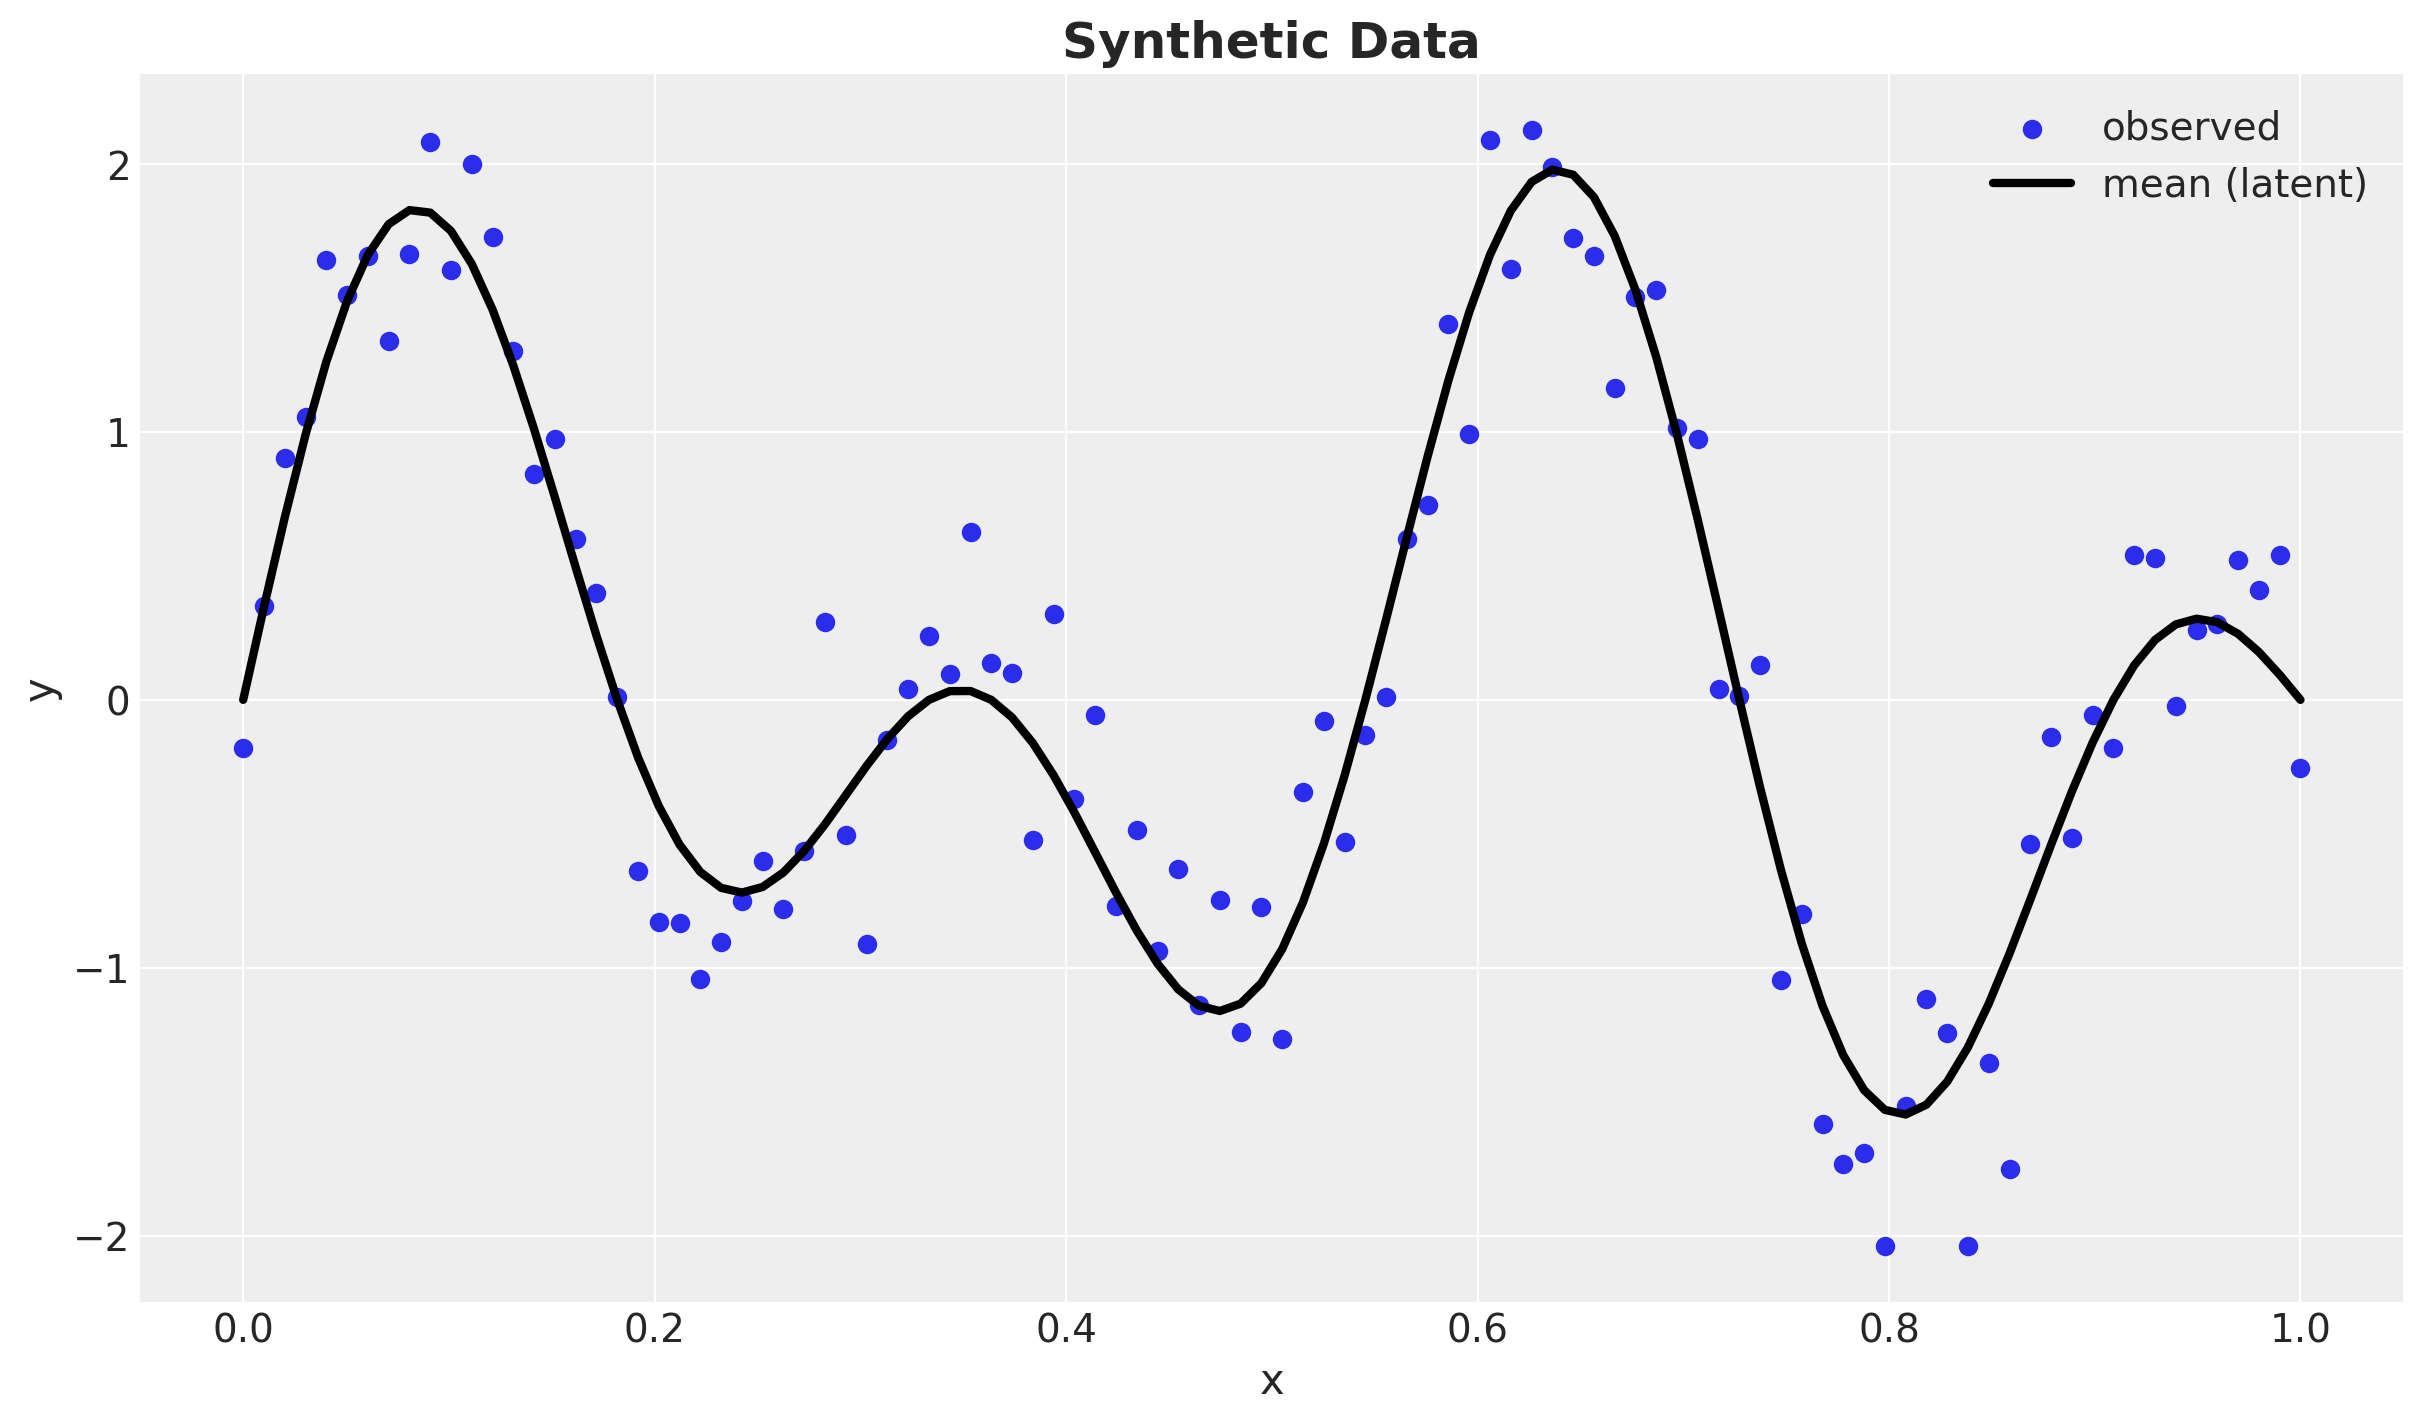

In [3]:
fig, ax = plt.subplots()
ax.scatter(x, y_obs, c="C0", label="observed")
ax.plot(x, y, color="black", linewidth=3, label="mean (latent)")
ax.legend(loc="upper right")
ax.set(xlabel="x", ylabel="y")
ax.set_title("Synthetic Data", fontsize=18, fontweight="bold")

In [4]:
# https://num.pyro.ai/en/stable/examples/gp.html
def squared_exponential_kernel(x0, x1, var, length, noise, jitter=1.0e-6):
    delta = jnp.power((x0[:, None] - x1) / length, 2.0)
    k = var * jnp.exp(-0.5 * delta)
    k += (noise + jitter) * jnp.eye(x0.shape[0])
    return k

<Axes: >

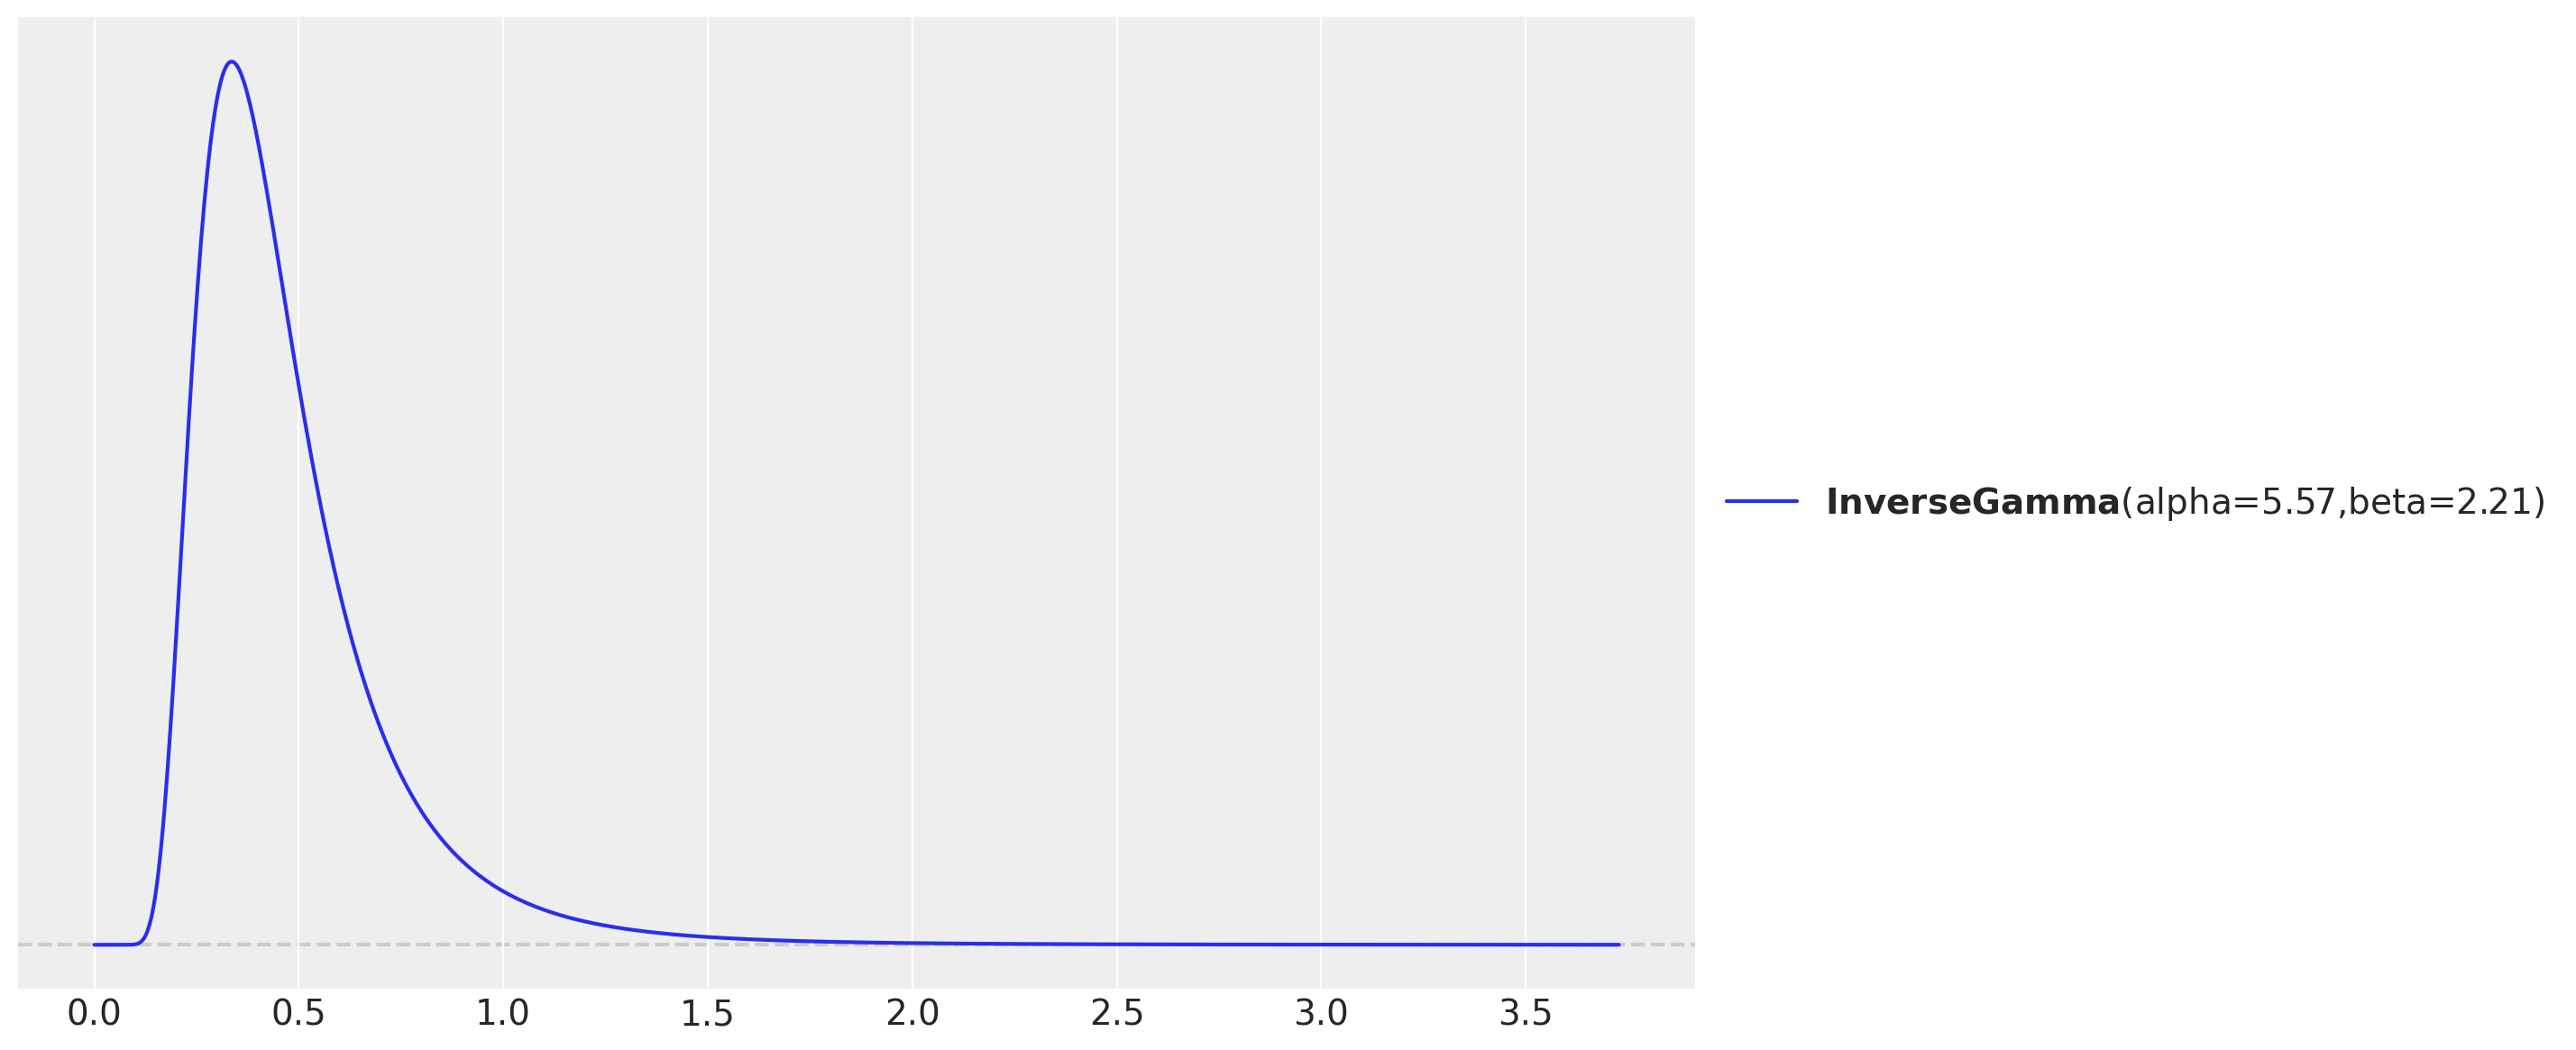

In [5]:
inverse_gamma_params = pm.find_constrained_prior(
    distribution=pm.InverseGamma,
    lower=0.01,
    upper=0.9,
    init_guess={"alpha": 5, "beta": 3},
    mass=0.94,
)

fig, ax = plt.subplots()
pz.InverseGamma(**inverse_gamma_params).plot_pdf(ax=ax)

In [6]:
def gp_model(x, y=None) -> None:
    var = numpyro.sample(
        "kernel_var",
        dist.InverseGamma(
            concentration=inverse_gamma_params["alpha"],
            rate=inverse_gamma_params["beta"],
        ),
    )
    noise = numpyro.sample(
        "kernel_noise",
        dist.InverseGamma(
            concentration=inverse_gamma_params["alpha"],
            rate=inverse_gamma_params["beta"],
        ),
    )
    length = numpyro.sample(
        "kernel_length",
        dist.InverseGamma(
            concentration=inverse_gamma_params["alpha"],
            rate=inverse_gamma_params["beta"],
        ),
    )

    kernel = squared_exponential_kernel(x, x, var, length, noise)

    numpyro.sample(
        "likelihood",
        dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=kernel),
        obs=y,
    )

In [7]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc


inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
gp_mcmc = run_inference(rng_subkey, gp_model, inference_params, x, y_obs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
gp_numpyro_idata = az.from_numpyro(posterior=gp_mcmc)

az.summary(data=gp_numpyro_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel_length,0.097,0.009,0.080,0.114,0.000,0.00,4150.0,4269.0,1.0
kernel_noise,0.134,0.020,0.099,0.172,0.000,0.00,4897.0,4419.0,1.0
kernel_var,1.601,0.772,0.591,2.981,0.013,0.01,4239.0,3942.0,1.0


Text(0.5, 0.98, 'GP NumPyro - Trace')

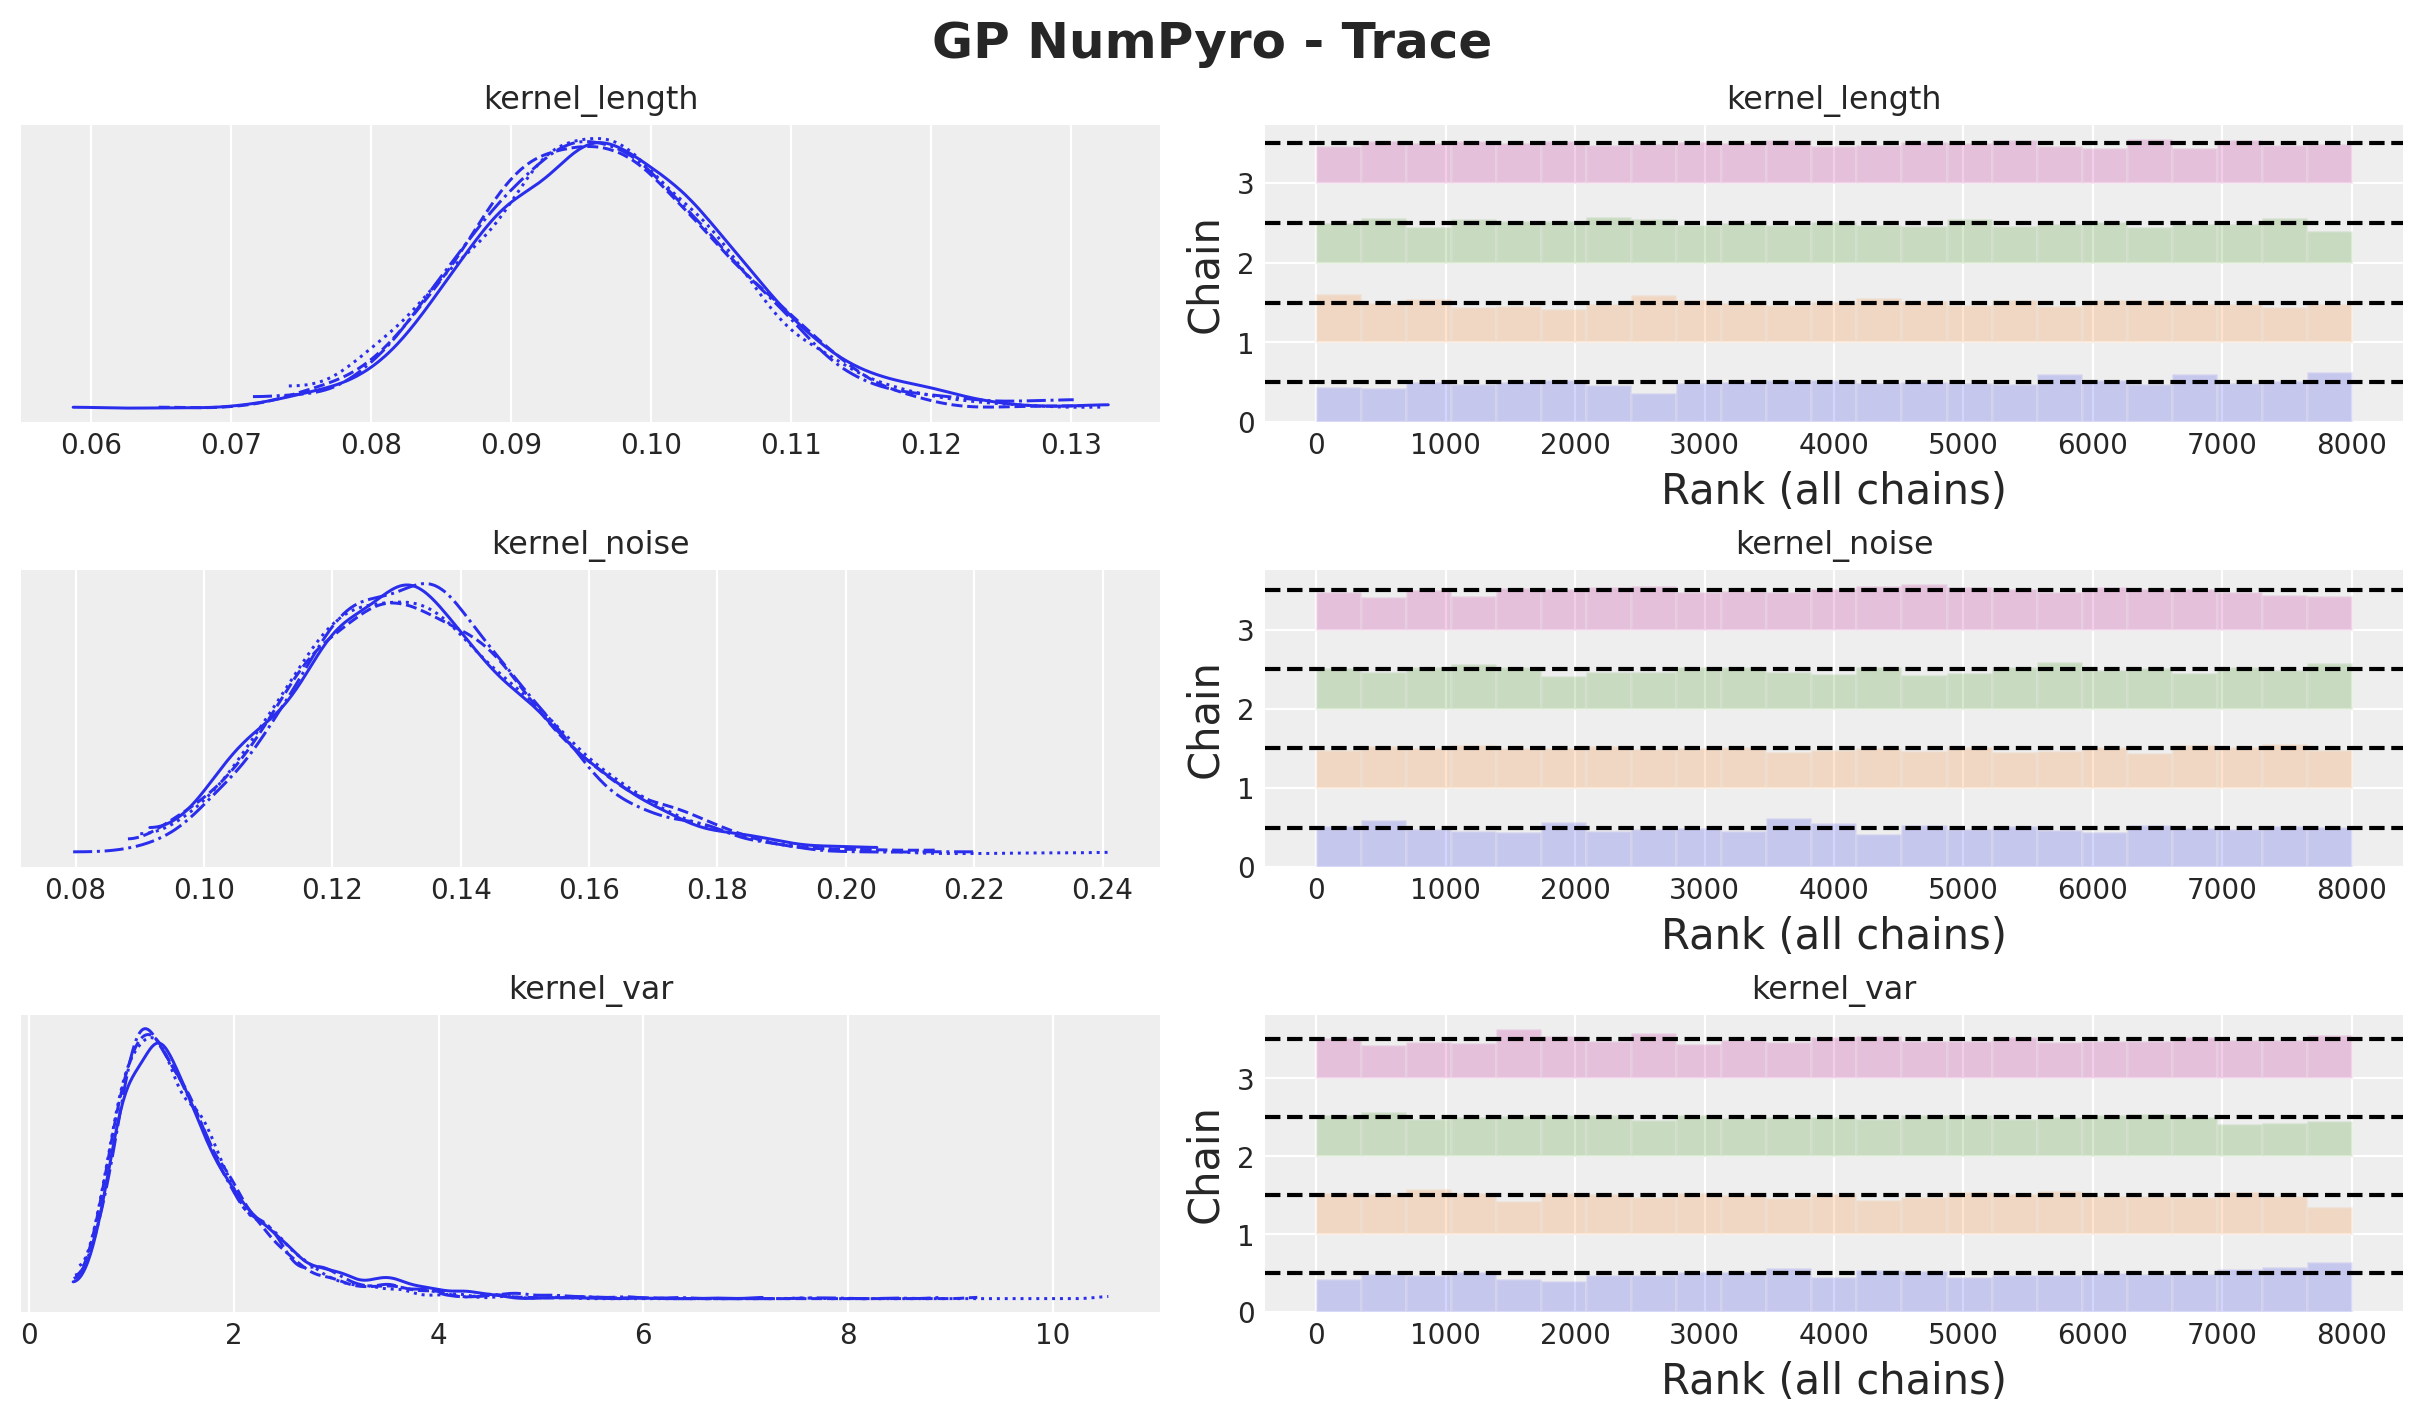

In [9]:
axes = az.plot_trace(
    data=gp_numpyro_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("GP NumPyro - Trace", fontsize=18, fontweight="bold")

In [10]:
def posterior_predictive(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["likelihood"],
    )
    return predictive(rng_key, *model_args)


rng_key, rng_subkey = random.split(key=rng_key)
gp_numpyro_posterior_predictive = posterior_predictive(
    rng_subkey,
    gp_model,
    gp_mcmc.get_samples(),
    x,
)

gp_numpyro_idata.extend(
    az.from_numpyro(
        posterior_predictive=gp_numpyro_posterior_predictive,
    )
)

Text(0.5, 1.0, 'Synthetic Data')

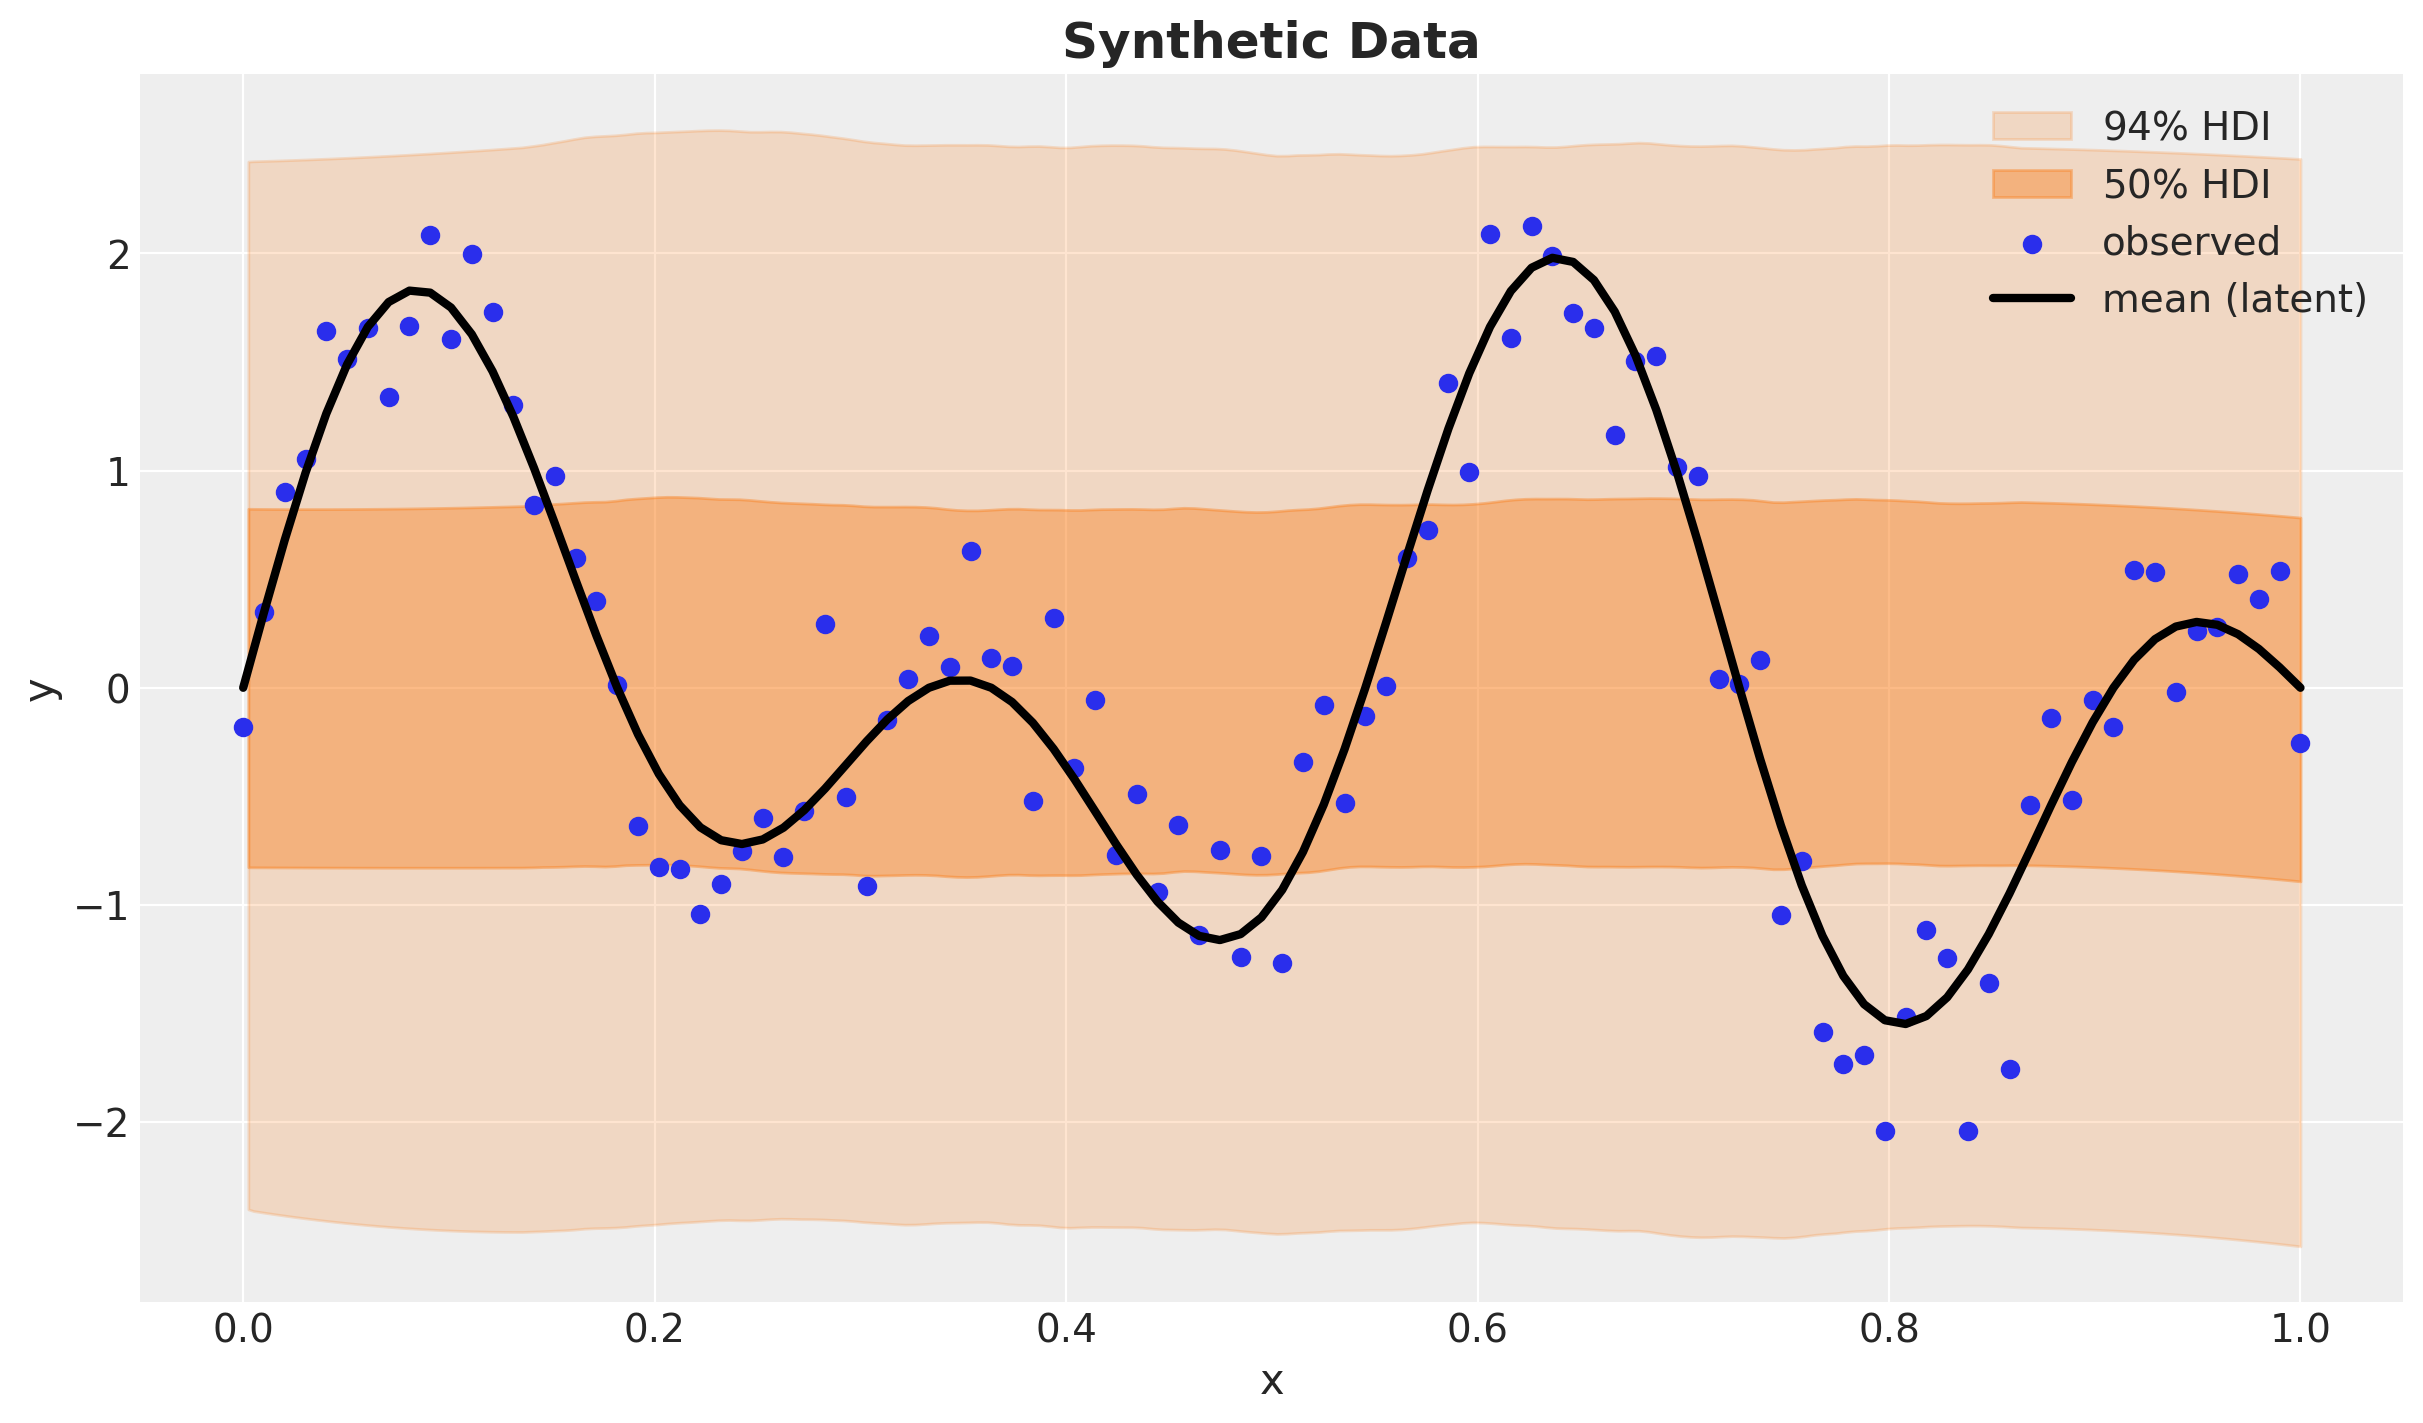

In [11]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=x,
    y=gp_numpyro_idata.posterior_predictive.likelihood,
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
)
az.plot_hdi(
    x=x,
    y=gp_numpyro_idata.posterior_predictive.likelihood,
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
)
ax.scatter(x, y_obs, c="C0", label="observed")
ax.plot(x, y, color="black", linewidth=3, label="mean (latent)")
ax.legend(loc="upper right")
ax.set(xlabel="x", ylabel="y")
ax.set_title("Synthetic Data", fontsize=18, fontweight="bold")